## Decentralized Edge-learning Example
This notebook illustrates how to jointly train a simple neural network for a binary classification problem on two satellites in orbit around Earth.

To begin, let us import all the necessary modules.

In addition to PASEOS's requirements, this notebook uses torch and scikit-learn. These may be installed as `conda install -c pytorch pytorch` and `conda install -c anaconda scikit-learn`. 

In [ ]:
import sys 
sys.path.append("../..")

import asyncio
import numpy as np
from matplotlib import pyplot as plt
import paseos
import pykep as pk
from simple_node import Node

paseos.set_log_level("INFO") # reduce the log output

### Create two nodes orbiting Earth in different directions
We use a Node class (see `node.py`) that encapsulates a PASEOS instance along with a neural network (along with its training/evaluation routines) that is loaded with data (see `simple_neural_network.py` for details). The Node provides utility functions, e.g., to check for line-of-sight and to add awareness of other nodes. Furthermore, the node registers two activities with PASEOS to perform training & evaluation of the neural network and to communicate the model parameters to neighboring nodes.

Below, we create two nodes in a Walker constellation with opposite directions. We set the time_multiplier to 1000, i.e., 1 second in real time corresponds to 1000 seconds in the simulation. This is done to emulate a heavy training load of the neural network.

In [2]:
# Speed up simulation
paseos_cfg = paseos.load_default_cfg()  # loading paseos cfg to modify defaults
paseos_cfg.sim.time_multiplier = 1000
        
power_consumption_in_watt = 5

# Create nodes
pos1 = [-6361974.5152151017, 52215.393130868499, -345258.19754751836]
vel = [433.46690432313761, 1180.9649876192523, -7808.7670808152052]
node1 = Node(1, [pos1, vel], paseos_cfg, power_consumption_in_watt)

pos2 = [6361974.5152151017, -52215.393130868615, 345258.19754751911]
node2 = Node(2, [pos2, vel], paseos_cfg, power_consumption_in_watt)

### Plot the nodes' datasets
The data consists of two-dimensional points belonging to an outer and an inner circle and the objective of the neural network is to classify to what circle a given 2D point belongs to.
The training data is partitioned over the satellites such that node1 only has access to training data that is positive in the first dimension whereas node2 only has access to training data that is negative in the first dimension.

Both the nodes are evaluated on a common test dataset that contains points from both the inner and the outer circles.

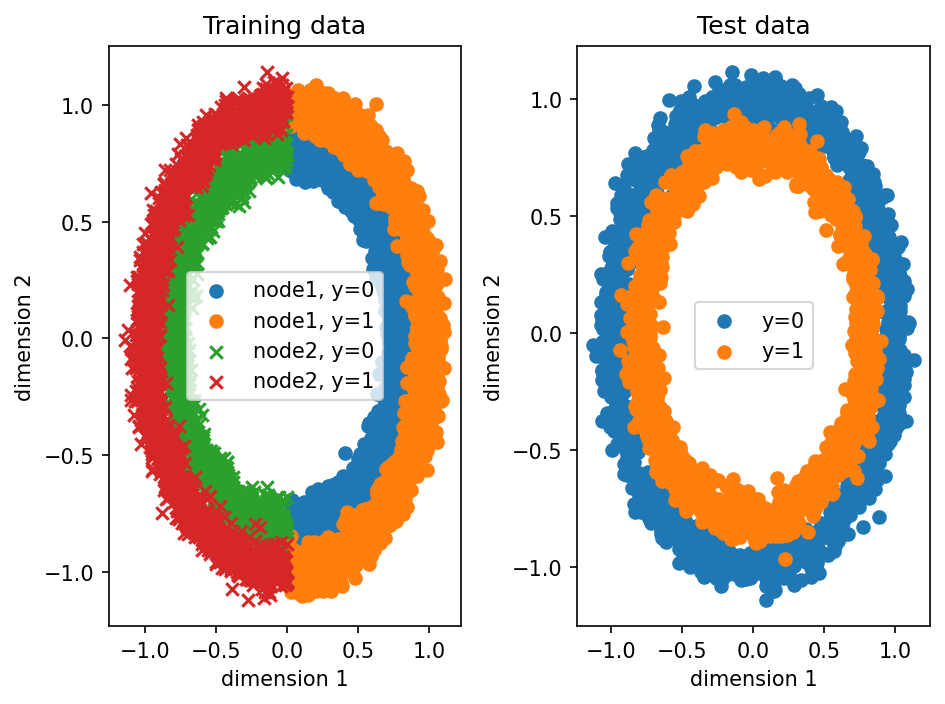

In [3]:
fig, axes = plt.subplots(1,2, dpi=150)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

X1 = np.asarray(node1.model.train_dataloader.dataset.X)
y1 = np.asarray(node1.model.train_dataloader.dataset.y)
axes[0].scatter(X1[y1==1,0], X1[y1==1,1], label = "node1, y=0", color=colors[0])
axes[0].scatter(X1[y1==0,0], X1[y1==0,1], label = "node1, y=1", color=colors[1])

X2 = np.asarray(node2.model.train_dataloader.dataset.X)
y2 = np.asarray(node2.model.train_dataloader.dataset.y)
axes[0].scatter(X2[y2==1,0], X2[y2==1,1],marker='x', label = "node2, y=0", color=colors[2])
axes[0].scatter(X2[y2==0,0], X2[y2==0,1],marker='x', label = "node2, y=1", color=colors[3])
axes[0].set_title("Training data")
axes[0].set_xlabel("dimension 1")
axes[0].set_ylabel("dimension 2")
axes[0].legend()

X = np.asarray(node1.model.test_dataloader.dataset.X)
y = np.asarray(node1.model.test_dataloader.dataset.y)
axes[1].scatter(X[y==0,0], X[y==0,1], label= "y=0")
axes[1].scatter(X[y==1,0], X[y==1,1], label= "y=1")
axes[1].set_title("Test data")
axes[1].set_xlabel("dimension 1")
axes[1].set_ylabel("dimension 2")
axes[1].legend();
fig.tight_layout()

### Train the two nodes
Simulate training over three orbital revolutions. The satellites will perform training if the state of charge is above 20%. If below 20%, the satellites are in standby and consume no battery. Whenever the satellites are in line-of-sight, they share their model parameters and aggregates thse with their current model parameters.

Note: animation will not work in VSCode due to magic command

<IPython.core.display.Javascript object>


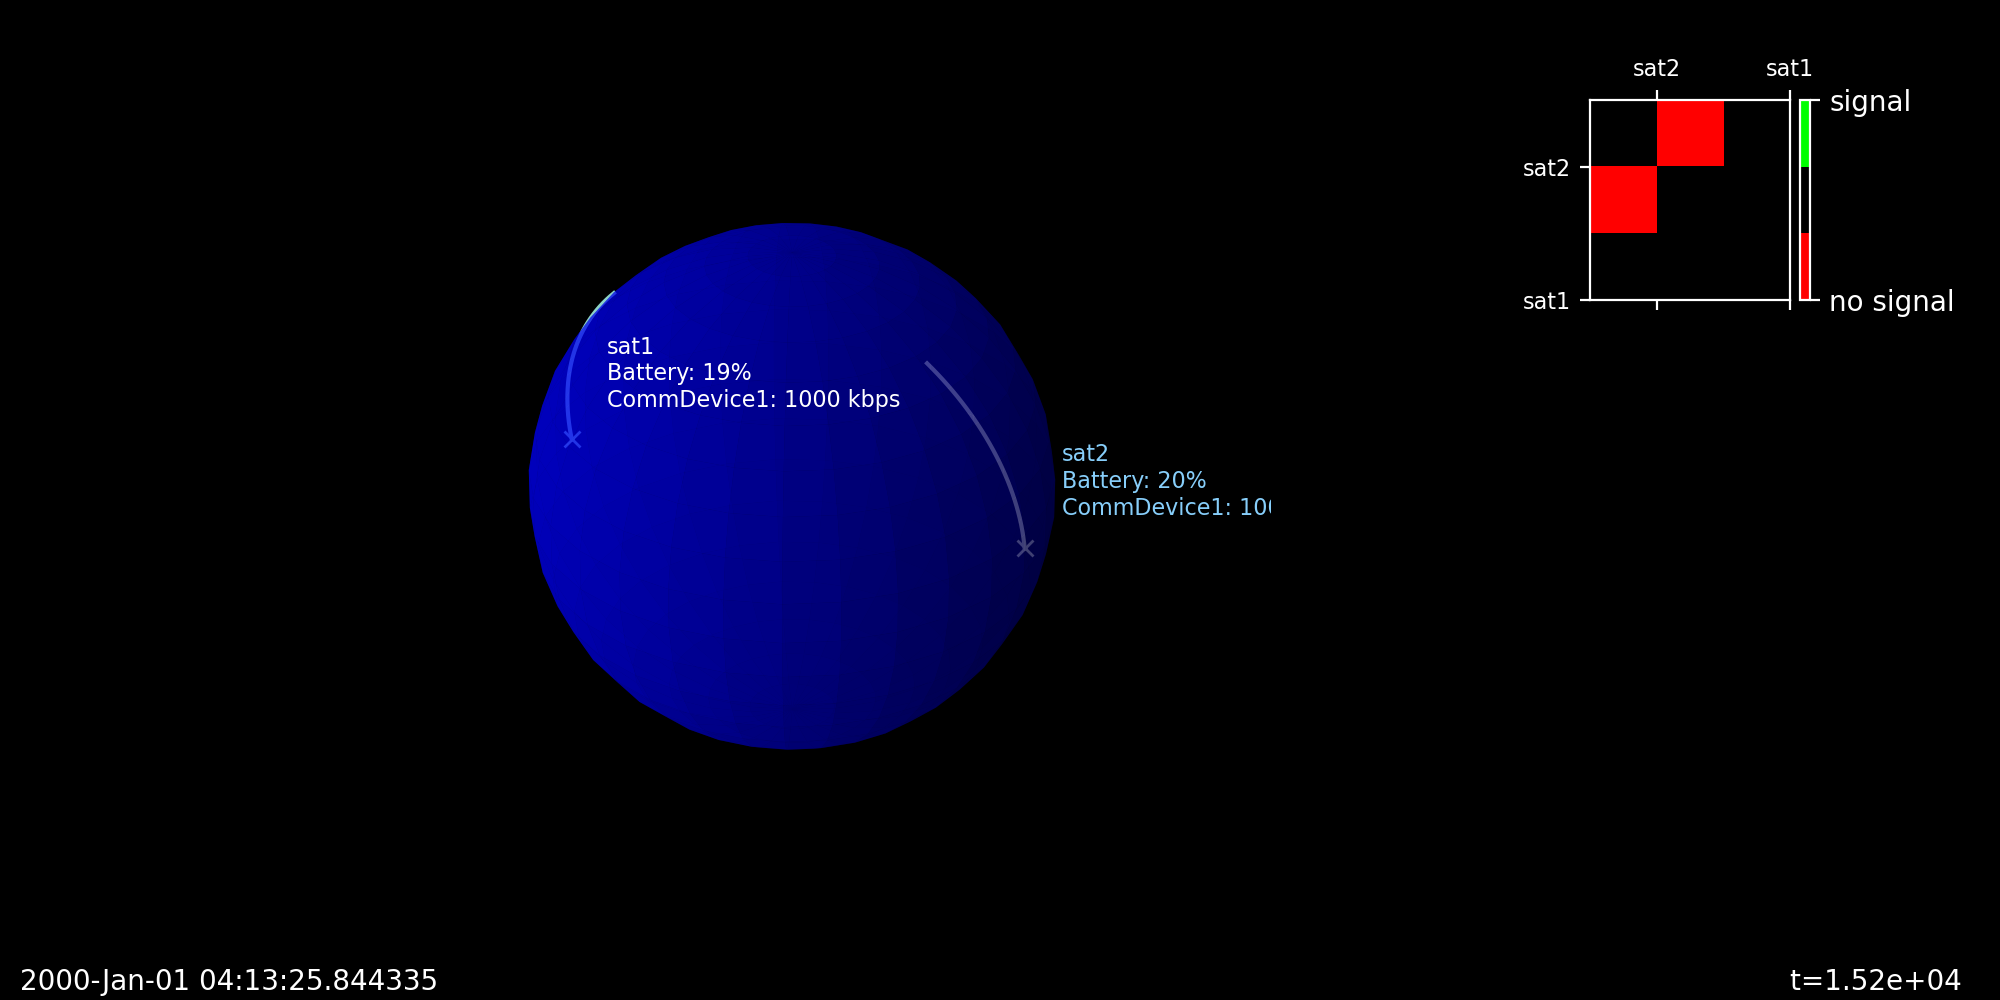

In [4]:
%matplotlib notebook
plotter = paseos.plot(node1.paseos, paseos.PlotType.SpacePlot)

test_accuracy_node1 = []
test_accuracy_node2 = []
time_share = []
time_steps = []

orbital_period = 5061.492804584637
target_orbits = 3

# Add node2 to node1 so it shows in animation
node1.add_known_node(node2)

# Perform simulation from node1's point of view
orbits = 0
while orbits < target_orbits:
    if node1.in_in_line_of_sight(node2) and node1.transmission_is_feasible(node2):
        # save sharing time
        time_share.append(True) 
        
        # Simulate communication with an activity that lasts for node1.transmit_duration
        await node1.paseos.perform_activity("Communicate")
        
        # Merge the models
        node1.merge_model(node2.model)
        node2.merge_model(node1.model)
    else:
        time_share.append(False) 
    
    # Train models if enough battery otherwise standby
    for node, test_accuracy in [(node1, test_accuracy_node1), (node2, test_accuracy_node2)]:
        activity = node.activity_scheduler()
        if activity == "train":
            await node.paseos.perform_activity("Train", test_accuracy)
        elif activity == "standby":
            await node.paseos.perform_activity("StandBy", test_accuracy)

    # Add time
    time_steps.append(node1.local_time().mjd2000*pk.DAY2SEC) 
    orbits = time_steps[-1] / orbital_period
    plotter.update(node1.paseos)
    

orbital_revolutions = np.asarray(time_steps) / orbital_period

### Plot Test Accuracy and State of Charge
The figures below illustrate the test accuracy and the state of charge of the two nodes and at what times the models are shared.


<IPython.core.display.Javascript object>


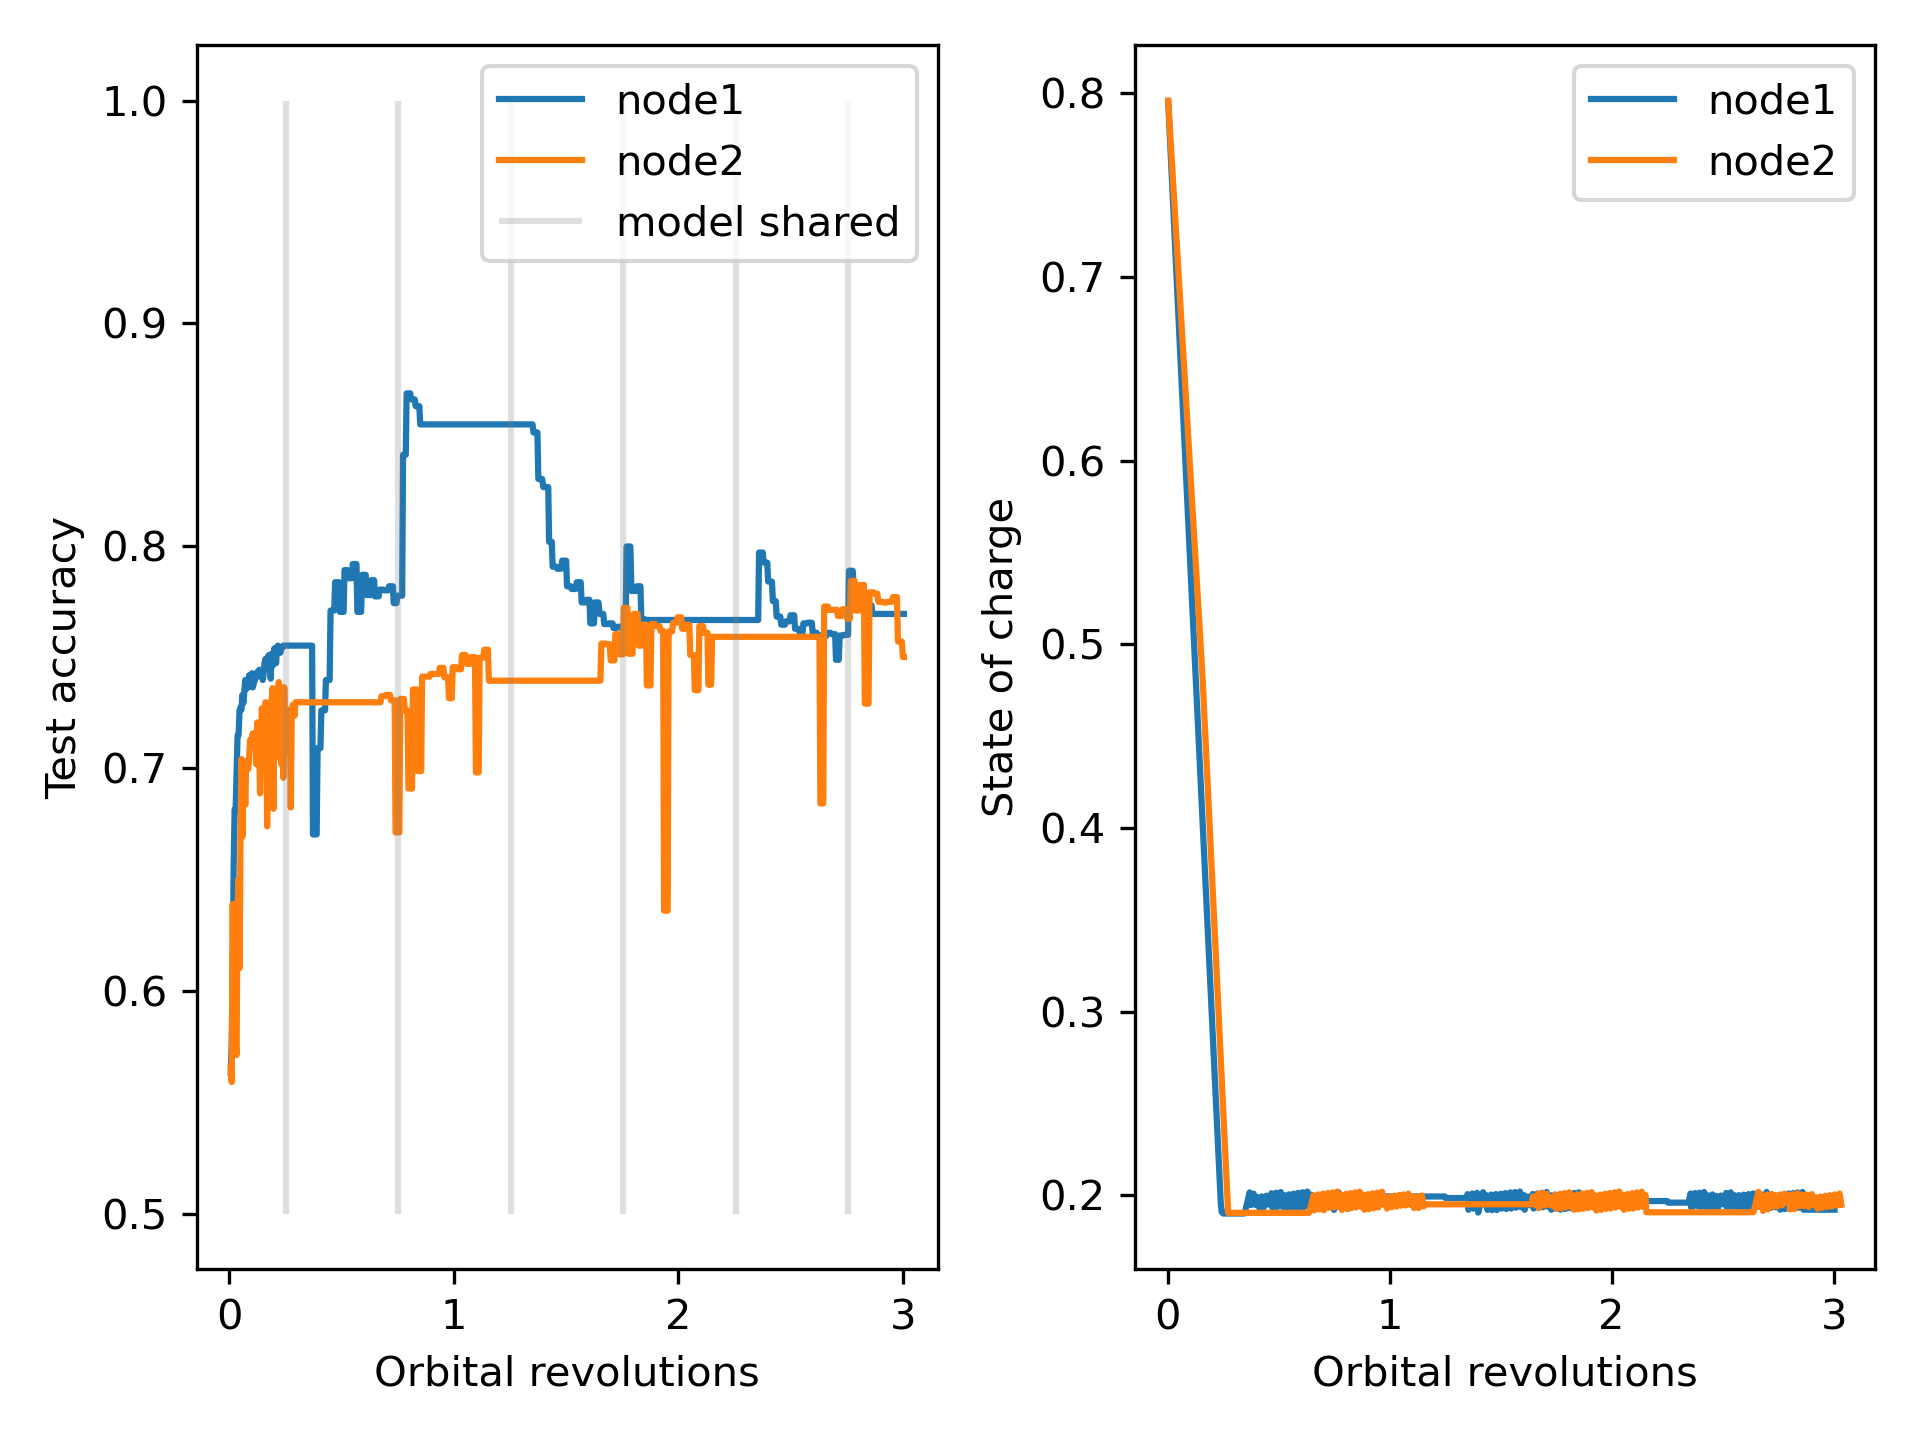

In [5]:
fig, axes = plt.subplots(1,2, dpi=150)
axes[0].plot(orbital_revolutions, test_accuracy_node1, label="node1")
axes[0].plot(orbital_revolutions, test_accuracy_node2, label="node2")
# mark rounds where models are shared
axes[0].vlines(orbital_revolutions[time_share], 0.5, 1, color="grey", alpha=0.25,  label="model shared")
axes[0].set_ylabel("Test accuracy")
axes[0].set_xlabel("Orbital revolutions")
axes[0].legend()

state_of_charge_node1 = node1.paseos.monitor["state_of_charge"]
state_of_charge_node2 = node2.paseos.monitor["state_of_charge"]
revolutions_node1 = np.asarray(node1.paseos.monitor["timesteps"]) / orbital_period 
revolutions_node2 = np.asarray(node2.paseos.monitor["timesteps"]) / orbital_period 
axes[1].plot(revolutions_node1, state_of_charge_node1, label="node1")
axes[1].plot(revolutions_node2, state_of_charge_node2, label="node2")
axes[1].set_ylabel("State of charge")
axes[1].set_xlabel("Orbital revolutions")
axes[1].legend();
fig.tight_layout()